# PSF normalization

Let us assume that we have reduced an observation, for which we have determined the PSF by stacking the flux of point-like sources. The PSF we obtain will not be as high S/N as the instrumental PSF that has been determined by the instrument team. Moreover, it is likely to be fattened due to the some small pointing errors. We need to find out what fraction of a point-like flux the PSF we have determined represent. In order to do this, we use the growth curve of the theoretical PSF that has been determine by the instrument team, and compare it to the growth curve we determine from our PSF.

We will first look at a theoretical case, then go practical with an example drawn from the PACS observation of the the XMM-LSS.

## 1) Theoretical example. 

Let us suppose we have a perfect telescope, without any central obscuration and spider to support the secondary. Diffraction theory gives us the shape of a PSF in this case, an Airy function. Let's compute it, and assume the resolution is 10".


In [1]:
# import what we will need. 
%matplotlib inline
import numpy as np
from astropy.io import fits
from astropy.table import Table
from astropy.io import ascii as asciiread
from matplotlib import pyplot as plt
from scipy import interpolate 
from scipy import special
from scipy import signal
from scipy import fftpack

In [2]:
# Let us perform our computation with a 0.1" resolution on a 5' field of view
resol = 0.1
size = 300.
# wavelength
wavelength = 250e-6
# primary aperture = 3.6 m diameter
aperture = 3.6 / 2.

In [3]:
# Ensure we have an odd number of points 
nbpix = np.ceil(size/resol) // 2 * 2 + 1
xcen = int((nbpix - 1) / 2)
ycen = int((nbpix - 1) / 2)
x = y = (np.arange(nbpix) - xcen)*resol
xv, yv = np.meshgrid(x, y, sparse=False, indexing='xy')
r = np.sqrt(xv**2+yv**2)
# avoid division by 0 problems in the center
r[xcen,ycen] = 1e-6
# coordinates in fourier
q = 2 * np.pi / wavelength * aperture * np.sin(r/3600.*np.pi/180.)

In [4]:
psf = (2*special.jn(1, q)/q)**2

In [5]:
# put back the correct value at center
psf[xcen, ycen] = 1.
# and normalize the PSF
psf = psf/(np.sum(psf)*resol**2)

$\int\int$ psf dx dy = 1.0000000000000018


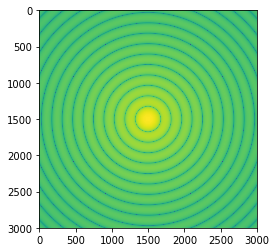

In [6]:
plt.imshow(np.log10(psf))
print(r'$\int\int$ psf dx dy = {}'.format(np.sum(psf)*resol**2))

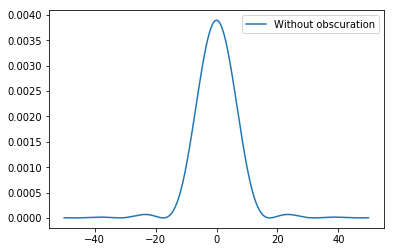

In [7]:
plt.plot(y[ycen-500:ycen+500], psf[ycen-500:ycen+500, xcen], label='Without obscuration')
plt.legend()

Let us now suppose that we observe a point source, and our image reconstruction has a ...This will shows a a blurring of the image, with a gaussian of 10" FWHM. Let's generate this blurring

In [8]:
fwhm = 10.
sigma = fwhm / 2. / np.sqrt(2. * np.log(fwhm))
sigmasq = sigma**2
kernel_blur = 1./ 2./ np.pi / sigmasq * np.exp(-(r**2/2./sigmasq))

In [9]:
# Check our kernel is properly normalized
np.sum(kernel_blur*resol**2)

0.9999999999999996

In [10]:
# apply the blur
psfblur = signal.convolve(psf, kernel_blur, mode='same')*resol**2

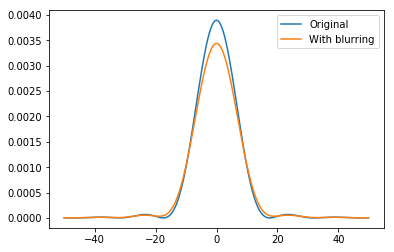

In [11]:
plt.plot(y[ycen-500:ycen+500], psf[ycen-500:ycen+500, xcen], label='Original')
plt.plot(y[ycen-500:ycen+500], psfblur[ycen-500:ycen+500, xcen], label='With blurring')
plt.legend()

We see the effect of blurring, the, observed PSF is wider, and we have lost some flux in the central core. Suppose now that we observed this psf with sources of unknown fluxes, so that we re unsure of its scaling, and that a background remain in our observation

In [12]:
psfobs = psfblur * 2. + 1e-4

The question is now how to recover the PSF that serve for our observation. For this, we will use the PSFs curve of growth. 

In [13]:
radii = np.arange(0, np.max(r), resol)
growth_psf = np.zeros(radii.shape)
growth_psfobs = np.zeros(radii.shape)
nbpix_psfobs = np.zeros(radii.shape)
for i, radius in enumerate(radii):
    if ((i % 100) == 0):
        print(radius, np.max(radii))
    if i == 0:
        idj, idi = np.where(r <= radius)
        growth_psf[i] = np.sum(psf[idj, idi])*resol**2
        growth_psfobs[i] = np.sum(psfobs[idj, idi])*resol**2
        nbpix_psfobs[i] =len(idi)
    else:
        idj, idi = np.where((r > radii[i-1]) & (r <= radius))
        growth_psf[i] = growth_psf[i-1]+np.sum(psf[idj, idi])*resol**2
        growth_psfobs[i] = growth_psfobs[i-1]+np.sum(psfobs[idj, idi])*resol**2
        nbpix_psfobs[i] = nbpix_psfobs[i-1]+len(idi)

0.0 212.10000000000002
10.0 212.10000000000002
20.0 212.10000000000002
30.0 212.10000000000002
40.0 212.10000000000002
50.0 212.10000000000002
60.0 212.10000000000002
70.0 212.10000000000002
80.0 212.10000000000002
90.0 212.10000000000002
100.0 212.10000000000002
110.0 212.10000000000002
120.0 212.10000000000002
130.0 212.10000000000002
140.0 212.10000000000002
150.0 212.10000000000002
160.0 212.10000000000002
170.0 212.10000000000002
180.0 212.10000000000002
190.0 212.10000000000002
200.0 212.10000000000002
210.0 212.10000000000002


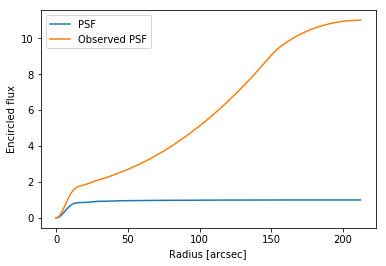

In [14]:
plt.plot(radii, growth_psf, label='PSF')
plt.plot(radii, growth_psfobs, label='Observed PSF')
plt.xlabel('Radius [arcsec]')
plt.ylabel('Encircled flux')
plt.legend()

This strongly rising shape of the observed PSF is a sure sign of an non zero background. Let's determine it. 

Text(0, 0.5, 'Encircled flux')

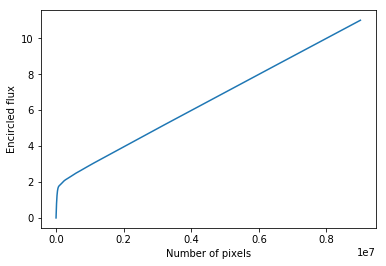

In [15]:
plt.plot(nbpix_psfobs, growth_psfobs)
plt.xlabel('Number of pixels')
plt.ylabel('Encircled flux')

When plotted as a function of the intergated area, there is a clear linear relation, that we will fit:

In [16]:
idx, = np.where(radii > 50)
p = np.polyfit(nbpix_psfobs[idx], growth_psfobs[idx], 1)
bkg = p[0]/resol**2

In [17]:
# Correct PSF and curve of growth
psfcor = psfobs-bkg
growth_psfcor = growth_psfobs - bkg*nbpix_psfobs*resol**2

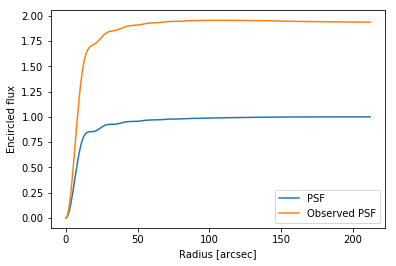

In [18]:
plt.plot(radii, growth_psf, label='PSF')
plt.plot(radii, growth_psfcor, label='Observed PSF')
plt.xlabel('Radius [arcsec]')
plt.ylabel('Encircled flux')
plt.legend()

<a id='direct_ratio'></a> Let's have a look at the ratio of the two:

Text(0, 0.5, 'Ratio of encircled flux')

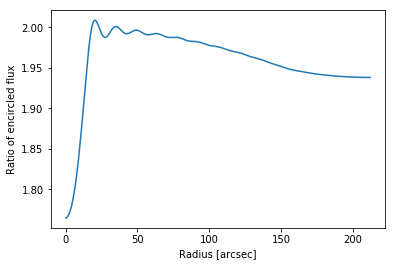

In [19]:
plt.plot(radii[1:], growth_psfcor[1:]/growth_psf[1:])
plt.xlabel('Radius [arcsec]')
plt.ylabel('Ratio of encircled flux')


Due to the different resolution, the ratio is not constant. Let's note the calibration $C(r)$. Let us assume that our observed PSF encirled energy is of the form:

$E(r) = \alpha C(r \times \beta)$

Where $\beta$ is the fattening of the PSF. If we differentiate as a function of $r$:

$E'(r) = \alpha \beta C'(r \times \beta)$



In [20]:
# compute the derivatives
deriv_growth_psf = (growth_psf[2:]-growth_psf[0:-2])/(radii[2:]-radii[0:-2])
deriv_growth_psfcor  = (growth_psfcor[2:]-growth_psfcor[0:-2])/(radii[2:]-radii[0:-2])

(0, 60)

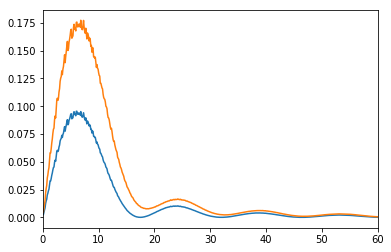

In [21]:
plt.plot(radii[1:-1], deriv_growth_psf)
plt.plot(radii[1:-1], deriv_growth_psfcor)
plt.xlim([0,60])

Compared with the growth curve plot, the derivative show clear maxima and minima that are out of phase. Findind the positions of the these will tell us if our assumption of homothetical variation is correct.

[ 0.          6.18050404 17.4854638  23.79928199 32.07353691 38.40607579
 46.76238796] [ 0.          6.5206172  18.75895207 24.07489413 32.78746844 38.5386345
 47.21468159]


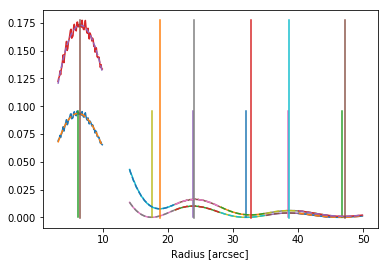

In [22]:
# Find the local minima and maxima of the two curves.
# To find a local extremum, we will fit the portion of curve with a degree 3 polynomial, 
# extract the roots of its derivative and only retain the one that are between the bounds.
# This is what the following function does.
def local_max(xvalues, yvalues, lower_bound, upper_bound, check_plot=False):
    idx,=np.where((xvalues > lower_bound) & (xvalues < upper_bound))
    p = np.polyfit(xvalues[idx], yvalues[idx], 3)
    delta = (2.*p[1])**2 - 4.*3.*p[0]*p[2]
    r1 = (-2*p[1]+np.sqrt(delta))/(2*3*p[0])
    r2 = (-2*p[1]-np.sqrt(delta))/(2*3*p[0])
    result = r1 if ((r1 > lower_bound) and (r1 < upper_bound)) else r2
    if check_plot:
        plt.plot(xvalues[idx], yvalues[idx])
        plt.plot(xvalues[idx], p[0]*xvalues[idx]**3+p[1]*xvalues[idx]**2+
                 p[2]*xvalues[idx]+p[3], '--')
        plt.plot(np.array([result, result]), np.array([np.min(yvalues), np.max(yvalues)]), '-')
    return result
    
    
max_dpsf_1 = local_max(radii[1:-1], deriv_growth_psf, 3, 10, check_plot=True)
max_dpsfcor_1 = local_max(radii[1:-1], deriv_growth_psfcor, 3, 10, check_plot=True)

max_dpsf_2 = local_max(radii[1:-1], deriv_growth_psf, 14, 21, check_plot=True)
max_dpsfcor_2 = local_max(radii[1:-1], deriv_growth_psfcor, 14, 21, check_plot=True)

max_dpsf_3 = local_max(radii[1:-1], deriv_growth_psf, 21, 28, check_plot=True)
max_dpsfcor_3 = local_max(radii[1:-1], deriv_growth_psfcor, 21, 28, check_plot=True)

max_dpsf_4 = local_max(radii[1:-1], deriv_growth_psf, 28, 35, check_plot=True)
max_dpsfcor_4 = local_max(radii[1:-1], deriv_growth_psfcor, 28, 35, check_plot=True)

max_dpsf_5 = local_max(radii[1:-1], deriv_growth_psf, 35, 45, check_plot=True)
max_dpsfcor_5 = local_max(radii[1:-1], deriv_growth_psfcor, 35, 45, check_plot=True)

max_dpsf_6 = local_max(radii[1:-1], deriv_growth_psf, 40, 50, check_plot=True)
max_dpsfcor_6 = local_max(radii[1:-1], deriv_growth_psfcor, 40, 50, check_plot=True)

plt.xlabel('Radius [arcsec]')

# Lets pack all of them, adding the r=0 point. 
max_dpsf = np.array([0, max_dpsf_1, max_dpsf_2, max_dpsf_3, max_dpsf_4, max_dpsf_5, max_dpsf_6])
max_dpsfcor = np.array([0, max_dpsfcor_1, max_dpsfcor_2, max_dpsfcor_3, max_dpsfcor_4, 
                        max_dpsfcor_5, max_dpsfcor_6])

print(max_dpsf,max_dpsfcor)

From the plot, we can deduce that our homothetical assumption is not perfect: the spacing increases for the first three (don't forget the point at 0, 0, not shown), is very small for the 4th and 6th, and gets narrower for the 5th and 7th...
Let's plot the situation

[ 1.07402639 -0.04610159]
1.0550300032613567
1.072831254463463


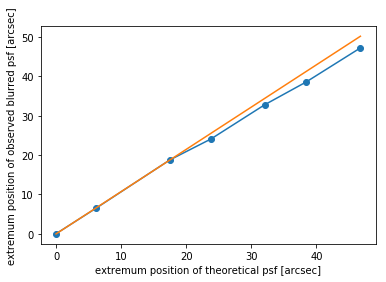

In [23]:
plt.plot(max_dpsf, max_dpsfcor, 'o-')
p = np.polyfit(max_dpsf[0:3], max_dpsfcor[0:3], 1)
plt.plot(max_dpsf, p[0]*max_dpsf+p[1])
plt.xlabel('extremum position of theoretical psf [arcsec]')
plt.ylabel('extremum position of observed blurred psf [arcsec]')


print(p)
print((max_dpsfcor[1]-max_dpsfcor[0])/(max_dpsf[1]-max_dpsf[0]))
print((max_dpsfcor[2]-max_dpsfcor[0])/(max_dpsf[2]-max_dpsf[0]))



Text(0, 0.5, 'Encircled flux')

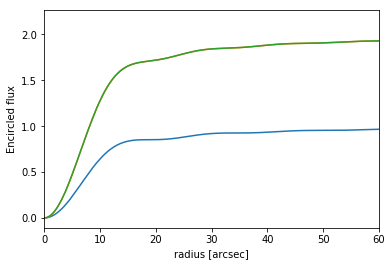

In [24]:
# Lets use the data before 20", corresponding to the central core
beta = (max_dpsfcor[2]-max_dpsfcor[0])/(max_dpsf[2]-max_dpsf[0])

# lets interpolate at the scaled radius
tckpsfcor = interpolate.splrep(radii, growth_psfcor, s=0)
interp_growth_psfcor = interpolate.splev(radii*beta, tckpsfcor, der=0)

# check interpolation
plt.plot(radii*beta, growth_psf)
plt.plot(radii, growth_psfcor)
plt.plot(radii*beta, interp_growth_psfcor)
plt.xlim([0,60])
plt.xlabel('radius [arcsec]')
plt.ylabel('Encircled flux')



Let us check the ratio, using the psf with a corrected radius

alpha = 2.005


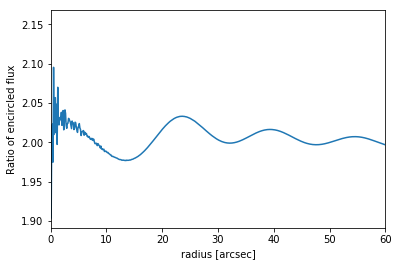

In [25]:
plt.plot(radii[1:]*beta, interp_growth_psfcor[1:]/growth_psf[1:])
plt.xlabel('radius [arcsec]')
plt.ylabel('Ratio of encircled flux')
plt.xlim([0,60])
idx, = np.where(((radii*p[0]) > 0) & ((radii*p[0]) < 60))
scale_factor = np.median(interp_growth_psfcor[idx]/growth_psf[idx])
print("alpha = {:.3f}".format(scale_factor))

We now have a much better looking ratio [compared with the cell where we computed the direct ratio](#the_ratio), and we have a decent determination of the psf scaling. The normalized PSF to use for our observations is then:

In [26]:
psf_obs_norm = psfcor / scale_factor

In [27]:
print('\int \int psf_obs_norm dx dy = {}'.format(np.sum(psf_obs_norm)*resol**2))

\int \int psf_obs_norm dx dy = 0.966450534666256


Indeed, let's look at the encircled energy in the core of our psf:
In this example, we have used the derivative of the scale factor

In [28]:
idj, idi = np.where(r<max_dpsfcor_2)
print('central core for observation: {}'.format(np.sum(psf_obs_norm[idj, idi])*resol**2))
idj, idi = np.where(r<max_dpsf_2)
print('central core for theoretical: {}'.format(np.sum(psf[idj, idi])*resol**2))




central core for observation: 0.8526531289184243
central core for theoretical: 0.8526789463354869


The two agree extremely well. 

Unfortunately, with real data, it is not always possible as we will see to use the derivative of the curve of growth to derive the factor beta of PSF fattening. For real observation, one can use a brute force approach to try all the reasonable couples alpha, beta and try to match the theoretical psf to the observed one. This is how we will proceed next on real data.

## 2) Real data: PACS observations

We will look at a real stack of point sources in the PACS ELAIS-N1 observations, and try to find its normalization factor. 

Let's load the stacked PSF:

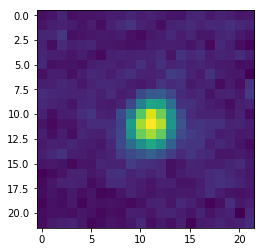

In [2]:
stackhd_im = fits.open('../dmu18_HELP-PACS-maps/data/AKARI-SEP_PACS160_v0.9.fits')
stackhd = fits.open('./data/output_data/160um/Akari-SEP-160um-psffromstack.fits')
psf = stackhd[0].data
hd = stackhd[0].header
plt.imshow(psf)

Set the resolution of the psf. Because the map is in units of Jy/pixel, this turns out to be:
* =1 if psf at same resolution of map
* otherwise, should be in factor of map pixel size

In [3]:
resol= np.abs(stackhd[0].header['CDELT1'])/np.abs(stackhd_im[1].header['CDELT1'])

In [4]:
resol

1.0

Now let's build the growthcurve for our PSF.

In [5]:
# find the brightest pixel, it will be our center.
jmax, imax = np.unravel_index(np.argmax(psf), psf.shape)

In [6]:
# build the array of coordinates
x = np.arange(hd['NAXIS1'])
y = np.arange(hd['NAXIS2'])
xv, yv = np.meshgrid(x, y, sparse=False, indexing='xy')
xp = (xv-imax)*np.abs(hd['CDELT1'])*3600.
yp = (yv-jmax)*np.abs(hd['CDELT2'])*3600.
r = np.sqrt(xp**2 + yp**2)


In [7]:
# build the growth curve
radii = np.unique(r)
encircled_flux = np.zeros(radii.shape)
nbpix = np.zeros(radii.shape)
for i, radius in enumerate(radii):
    idj, idi = np.where(r <= radius)
    nbpix[i] =len(idi)
    encircled_flux[i] = np.sum(psf[idj, idi])*resol**2
    #multiply by ((np.abs(hd['CDELT1'])*3600.)**2)/4.25E10 as map is in units of MJy/sr
    #encircled_flux[i] = np.sum(psf[idj, idi])*((np.abs(hd['CDELT1'])*3600.)**2)/4.25E10

In [8]:
hd['CDELT1']*3600.

-3.0000000726000002

Text(0, 0.5, 'Encircled flux')

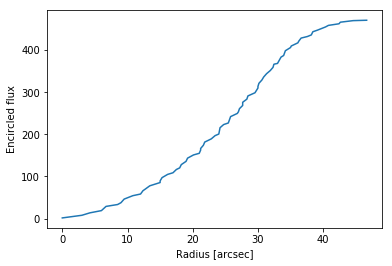

In [9]:
plt.plot(radii, encircled_flux)
plt.xlabel('Radius [arcsec]')
plt.ylabel('Encircled flux')

Looking at the shape of the encircled flux, it looks like the background level of our PSF is not zero. Let's check

In [10]:
# This is clearly. 
print(np.median(psf[0:5,:]))

0.9474514126777649


Text(0, 0.5, 'Encircled flux')

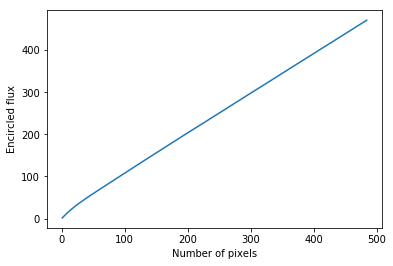

In [11]:
plt.plot(nbpix, encircled_flux)
plt.xlabel('Number of pixels')
plt.ylabel('Encircled flux')

In [12]:
print(len(nbpix))
nbpix[30]

75


193.0

In [13]:
#Lets do a linear fit to the outer part of the curve to determine the backgound
p = np.polyfit(nbpix[30:], encircled_flux[30:], 1)
bkg = p[0]/resol**2

In [14]:
print(bkg)

0.9415934067198142


In [15]:
print(encircled_flux)

[  1.64017427   7.86728412  13.71506053  18.96334457  28.97605079
  33.4580462   37.80603093  46.33960372  54.43842     58.354826
  66.19761541  70.11429784  77.87086853  85.61929312  89.50988775
  97.26160991 104.9928962  108.8287999  116.5954864  120.44831032
 128.22586611 135.86632061 143.56726494 151.19170067 155.02477929
 162.70454809 166.50938058 174.11486101 181.71117032 189.31890035
 196.99790972 200.78730363 215.77730688 223.24414998 227.02630436
 234.57966757 242.17671749 249.68446377 253.4466522  260.9850927
 268.5651809  276.14899045 283.65333867 291.23259297 298.77913141
 302.55439135 310.04935747 313.75921389 321.22327879 328.81752211
 336.31324127 343.99563879 351.49786866 359.07016796 366.54928249
 368.43603918 372.22690728 383.43396488 387.24799928 398.5687291
 406.03801936 409.83157948 417.33111572 421.04249701 428.59759295
 432.33717185 436.09581274 443.61984971 447.381603   454.99641985
 458.71213251 462.54458389 466.31132439 470.01314476 470.93107244]


In [16]:
# Lets correct the psf and encircled flux
psf = psf - bkg
encircled_flux = encircled_flux - bkg * nbpix*resol**2

Text(0, 0.5, 'Encircled flux')

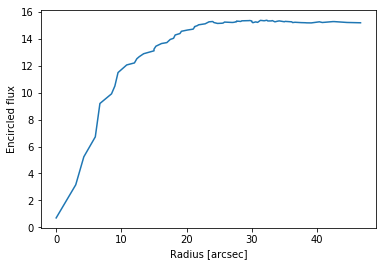

In [17]:
plt.plot(radii, encircled_flux)
plt.xlabel('Radius [arcsec]')
plt.ylabel('Encircled flux')

Our PSF does now behaves correctly.

Now let us compare our growth curve with the encircled energy curve provided by the instrument team. We use the standard growth curve for 160 µm PACS, taken with 20"/s scan speed. 

In [18]:
f = open('./data/EEF_red_20.txt', 'r')
lines = f.readlines()
f.close()
radiuseff = np.zeros(len(lines)-3)
valeff = np.zeros(len(lines)-3)
i = 0
for line in lines:
    if line[0] != '#':
        bits = line.split()
        radiuseff[i] = float(bits[0])
        valeff[i] = float(bits[1])
        i = i+1

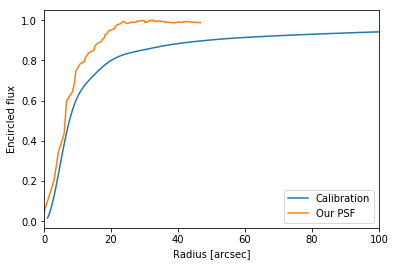

In [19]:
plt.plot(radiuseff, valeff, label='Calibration')
plt.plot(radii, encircled_flux/np.max(encircled_flux), label='Our PSF')
plt.xlim([0, 100])
plt.xlabel('Radius [arcsec]')
plt.ylabel('Encircled flux')
plt.legend()

We will work below 30" where our PSF is well behaved

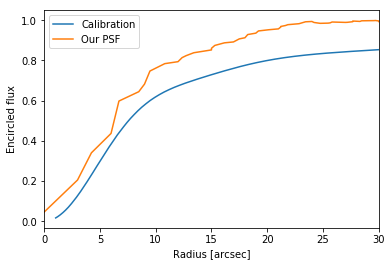

In [20]:
plt.plot(radiuseff, valeff, label='Calibration')
plt.plot(radii, encircled_flux/np.max(encircled_flux), label='Our PSF')
plt.xlim([0, 30])
plt.xlabel('Radius [arcsec]')
plt.ylabel('Encircled flux')
plt.legend()

We see that while the calibration curve still rises beyond 30", our PSF has reached a plateau. Let's note the calibration $C(r)$. Our PSF encirled energy is of the form:

$E(r) = \alpha C(r \times \beta)$

Where $\beta$ is the fattening of the PSF.

We could take the derivative, but this too noisy. Instead we do a brute force approach

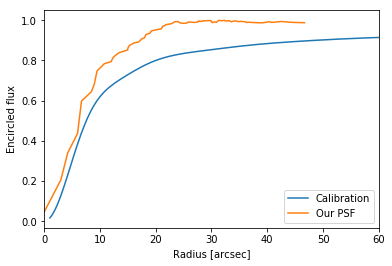

In [21]:
plt.plot(radiuseff, valeff, label='Calibration')
plt.plot(radii, encircled_flux/np.max(encircled_flux), label='Our PSF')
plt.xlim([0, 60])
plt.xlabel('Radius [arcsec]')
plt.ylabel('Encircled flux')
plt.legend()

In [22]:
rfactor = np.arange(1.,2., 1e-3)
ffactor = np.arange(1.,2., 1e-3)
# work with the data points between 3 and 10"
idx, = np.where((radii > 1) & (radii < 7))
xv = radii[idx]
yv = encircled_flux[idx]/np.max(encircled_flux)
resid = np.zeros((len(rfactor), len(ffactor)))
for i, rf in enumerate(rfactor):
    #print(i, rf)
    tck = interpolate.splrep(radiuseff*rf, valeff, s=0)
    yfit = interpolate.splev(xv, tck, der=0)
    for j, ff in enumerate(ffactor):
        resid[i, j] = np.sum((yv-yfit*ff)**2)


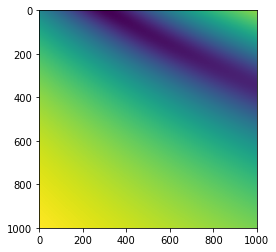

In [23]:
plt.imshow(np.log(resid))

This shows a minimum, with some degeneracy. 

In [24]:
imin = np.argmin(resid)
rmin, fmin = np.unravel_index(imin, resid.shape)
print("rf = {:.3f}, ff = {:.3f}, residual = {:.3f}".format(rfactor[rmin], ffactor[fmin], resid[rmin, fmin]))

rf = 1.000, ff = 1.305, residual = 0.008


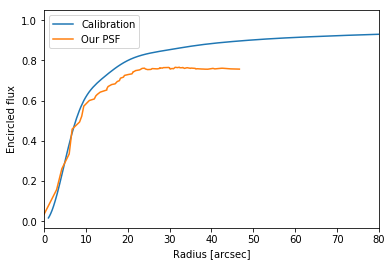

In [25]:
plt.plot(radiuseff*rfactor[rmin], valeff, label='Calibration')
plt.plot(radii, encircled_flux/np.max(encircled_flux)/ffactor[fmin], label='Our PSF')
plt.xlim([0, 80])
plt.xlabel('Radius [arcsec]')
plt.ylabel('Encircled flux')
plt.legend()

In [26]:
# The two curve overlap
psfok = psf/np.max(encircled_flux)/ffactor[fmin]
np.sum(psfok)

0.756886548931879

psfok is the PSF that a source of flux 1 Jy has in our data, and is to be used for source extraction

In [27]:
### As units of map in MJy/sr, divide by 1E6

In [28]:
#psfok=psfok/1.0E6
#psfok

### Validation
To check PSF is reasonable, lets look at a 160 micron source, e.g. `-------`. We can see from `AKARI-SEP_PACS160_v0.9.fits` that it has a flux of -- mJy. Maximum value in our normalised PSF gives a peak ---.

In [30]:
from astropy.table import Table

In [31]:
PACScat=Table.read('./data/AKARI-SEP_PACSxID24_v1.fits')

FileNotFoundError: [Errno 2] No such file or directory: './data/AKARI-SEP_PACSxID24_v1.fits'

In [32]:
PACScat['HELP_ID']

NameError: name 'PACScat' is not defined

In [33]:
PACScat[PACScat['HELP_ID']=='AKARI-SEP-PACSxID24-1-11000']

NameError: name 'PACScat' is not defined

In [34]:
cpix=np.int((hd['NAXIS1']+1)/2.0)

print("Max PSF = {:.4f} Jy/pix, off pixel Max PSF = {:.4f} Jy/pix".format(psfok[cpix-1,cpix-1]*0.004,psfok[cpix-3,cpix-3]*0.004))

Max PSF = 0.0001 Jy/pix, off pixel Max PSF = 0.0000 Jy/pix


/home/mc741/anaconda3/lib/python3.6/site-packages/mpl_toolkits/axes_grid/__init__.py:12: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.
  obj_type='module')


NameError: name 'PACScat' is not defined

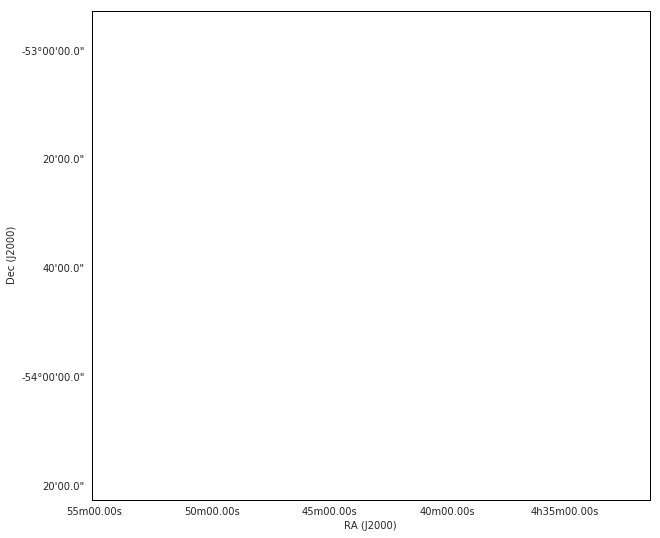

In [35]:
import aplpy
import seaborn as sns
sns.set_style("white")
cmap=sns.cubehelix_palette(8, start=.5, rot=-.75,as_cmap=True)
fig=aplpy.FITSFigure('../dmu18_HELP-PACS-maps/data/AKARI-SEP_PACS160_v0.9.fits')
fig.recenter(PACScat[PACScat['HELP_ID']=='AKARI-SEP-PACSxID24-1-69605']['RA'],PACScat[PACScat['HELP_ID']=='AKARI-SEP-PACSxID24-1-69605']['Dec'], radius=0.005)
fig.show_colorscale(vmin=-0.001,vmax=0.002,cmap=cmap)
fig.add_colorbar()
fig.colorbar.set_location('top')

In summary, the PSF is within 10% of this source, and given noise and shape of source will add additional uncertianty, as well as non-zero background, this seems reasonable.


In [36]:
stackhd[0].data=psfok
stackhd.writeto('dmu18_PACS_160_PSF_AKARI-SEP_20190125.fits',output_verify='fix+warn', overwrite=True)

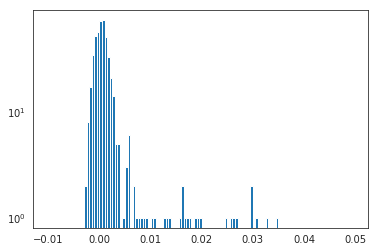

In [37]:
plt.hist(psfok.flatten(),bins=np.arange(-0.01,0.05,0.0005));
plt.yscale('log')

In [38]:
np.max(psfok)

0.034786263398731435